In [2]:
import yfinance as yf
import numpy as np
from ripser import Rips
import persim
import matplotlib.pyplot as plt

Now lets load in market data. Specifically, lets load some indices. To access them on yfinance, we need to add the ^ ticker

- GSPC is S&P 500
- DJI is Dow Jones
- IXIC is NASDAQ
- RUT is Russell 2000

In [6]:
index_names = ['^GSPC', '^DJI', '^IXIC', '^RUT']

In [8]:
#raw data is of the type Pandas Dataframe
raw_data = yf.download(index_names, start='2018-01-01', end='2022-04-21')

/var/folders/40/b39qh12x3dj80dkq4q34vz4h0000gn/T/ipykernel_91462/1620039481.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(index_names, start='2018-01-01', end='2022-04-21')
[*********************100%***********************]  4 of 4 completed


KeyError: 'Adj Close'

Lets retain only the closing prices

In [14]:
df_close = raw_data['Close'].dropna(axis='rows')

___Data Prep___ 

Now lets turn the df_close data into a numpy array

In [19]:
P = df_close.to_numpy()


#now we want an array of log return -- This is going to be the log of the ratio between closing values of two subsequent days

r = np.log(np.divide(P[1:],P[:len(P) - 1]))


Now lets get into some topological data analysis - Looking at how the homology of the market changes over time

Ripser is a Python library for computational topology, specifically 
designed for persistent homology computations. It is widely used in topological 
data analysis (TDA) to study the shape and structure of data.

Rips Class:
The Rips class in Ripser is used to instantiate a solver for computing 
persistent homology.


r[i:i+w]: First Time Window
This selects a chunk of data starting at index i and spanning w days (the time window size).
For example, if w = 20 and i = 0, this would represent the first 20 days of data: r[0:20].

r[i+w+1:i+(2*w)+1]: Second (Adjacent) Time Window
This selects the next chunk of data, starting right after the first time window and spanning another w days.
For example, if w = 20 and i = 0, this would represent the next 20 days of data: r[21:41].


The two time windows are adjacent but do not overlap. This ensures that the analysis compares non-overlapping segments of the data.
Comparing Changes:

By comparing the topology of r[i:i+w] and r[i+w+1:i+(2*w)+1], you can measure how the structure of the data evolves over time.
Flexibility:

This representation allows you to slide the time window across the dataset, enabling a rolling analysis of topological changes.
Example:
If r is a time series of log returns:

r[i:i+w] might represent the log returns for days 1–20.
r[i+w+1:i+(2*w)+1] might represent the log returns for days 21–40.
The Wasserstein distance between the persistence diagrams of these two windows quantifies the change in topology between these two periods.

In [ ]:
rips = Rips(maxdim=2) #this isntantiates Vietoris-Rips Solver

#now lets define a time window size that will let us grab a chunk of data to analyze homology
w = 20 #20 days is out time window size
n = len(raw_data)-(2*w)+1 #number of time segments 

wasserstein_dist = np.zeros((n,1)) #initializes an array of zeroes for wasserstein distances

# now lets also compute wasserstein distances between persistence diagrams for subsequent time windows

#first we take the first 20 rows of data to do persisten homology and create a persistence diagram
for i in range(n):
    
    #computing the persistance diagrams for adjacent time windows
    dgm1 = rips.fit_transform(r[i:i+w])
    dgm2 = rips.fit_transform(r[i+w+1:i+(2*w)+1])
    
    # Compute wasserstein distance between the diagrams - quantify the change in overall homology between the two persistence diagrams
    
    wasserstein_dist[i] = persim.wasserstein(dgm1[0], dgm2[0], matching=False)
    


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


/Users/dev/Desktop/Topology/.venv/lib/python3.9/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/dev/Desktop/Topology/.venv/lib/python3.9/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/dev/Desktop/Topology/.venv/lib/python3.9/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/dev/Desktop/Topology/.venv/lib/python3.9/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/dev/Desktop/Topology/.venv/lib/python3.9/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/dev/Desktop/Topology/.venv/lib/python3.9/site-packages/persim/wasserstein

Now for the plotting

Text(0.5, 1.0, 'Homology Changes Predicted Crash??')

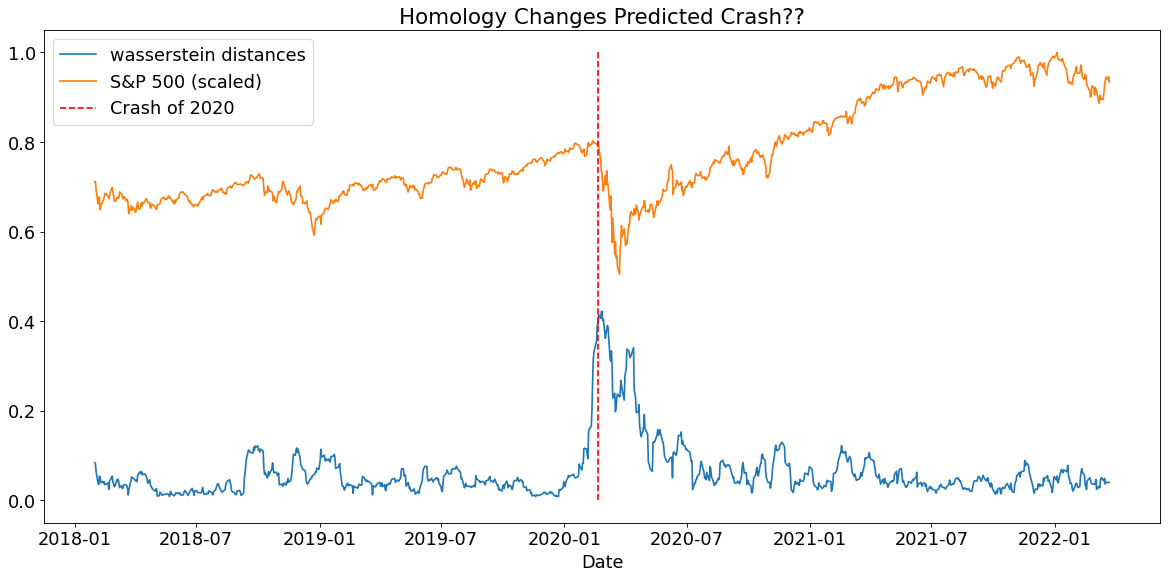

In [35]:
plt.figure(figsize=(18,8), dpi=80)
plt.rcParams.update({'font.size': 16})

plt.plot(raw_data.index[w:n+w], wasserstein_dist)
plt.plot(raw_data.index[w:n+w],df_close.iloc[w:n+w,0]/max(df_close.iloc[w:n+w,0]))
plt.plot([raw_data.index[536], raw_data.index[536]], [0, 1], 'r--')
plt.legend(['wasserstein distances', 'S&P 500 (scaled)', 'Crash of 2020'])
plt.xlabel('Date')
plt.title('Homology Changes Predicted Crash??')

